### Optimal control of phenomenological models, e.g. the FHN model
This notebook shows how to compute the optimal control (OC) signal for the FHN model for a simple example task. For the Hopf-model the OC can be computed completely analogously.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 3

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [2]:
# We import the model
fhn = FHNModel()
# hopf = HopfModel()    # OC can be computed for the Hopf model completely analogously

# Some parameters to define stimulation signals
dt = fhn.params["dt"]
duration = 10.
amplitude = 1.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-2] = np.sin(2.*np.pi*np.arange(0,duration-0.2, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
fhn.params["duration"] = duration
x_init = 0.
y_init = 0.
fhn.params["xs_init"] = np.array([[x_init]])
fhn.params["ys_init"] = np.array([[y_init]])

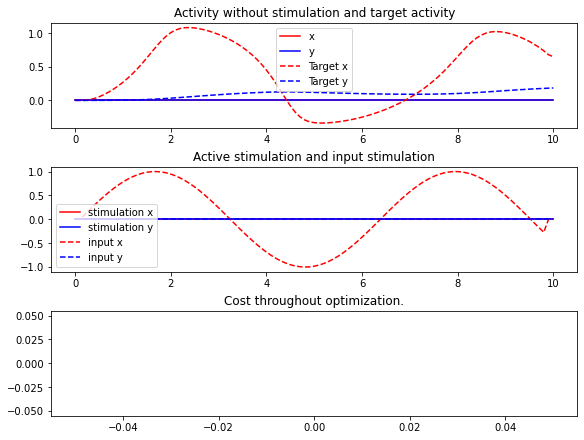

In [3]:
# We set the stimulus in x and y variables, and run the simulation
fhn.params["x_ext"] = input
fhn.params["y_ext"] = zero_input
fhn.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
fhn.params["x_ext"] = zero_input
fhn.params["y_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
fhn.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

Compute control for a deterministic system
Cost in iteration 1: 21.239994157998023


ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!


diverging model output, decrease step size to  5.0
diverging model output, decrease step size to  2.5
Cost in iteration 2: 17.176024936561863
diverging model output, decrease step size to  1.25
diverging model output, decrease step size to  0.625
Cost in iteration 100: 0.43808970986603085
Cost in iteration 200: 0.13752732606977264
Cost in iteration 300: 0.05855923455865154
Cost in iteration 400: 0.028612770904389986
Cost in iteration 500: 0.015587441292438208


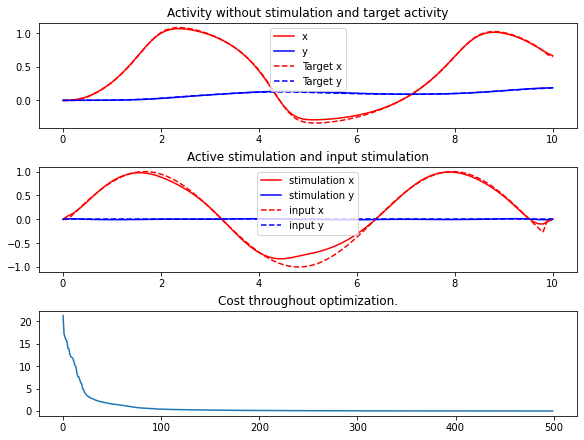

In [4]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
fhn.params["x_ext"] = zero_input
fhn.params["y_ext"] = zero_input
fhn_controlled = oc_fhn.OcFhn(fhn, target, w_p=1, w_2=0, print_array=[1,2,100,200,300,400,500])

# We run 500 iterations of the optimal control gradient descent algorithm
fhn_controlled.optimize(500)

state = fhn_controlled.get_xs()
control = fhn_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, fhn_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 1: 0.015431554266084233
Cost in iteration 2: 0.015327628770556686
Cost in iteration 100: 0.008990633031360187


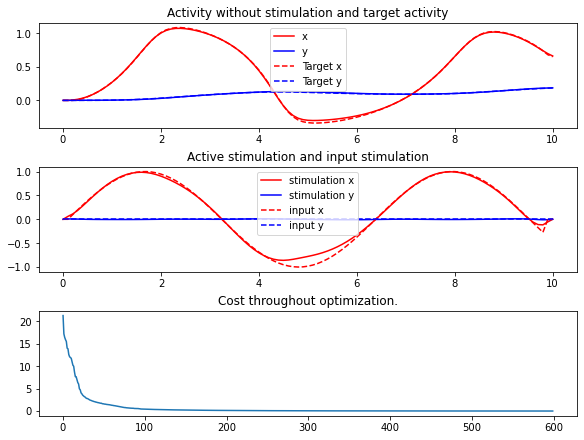

In [5]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
fhn_controlled.optimize(100)
state = fhn_controlled.get_xs()
control = fhn_controlled.control
plot_oc_singlenode(duration, dt, state, target, control, target_input, fhn_controlled.cost_history)

### Network case

Let us know study a simple 2-node network of FHN oscillators. We first need to define the coupling matrix and the delay matrix. We can then initialize the model.

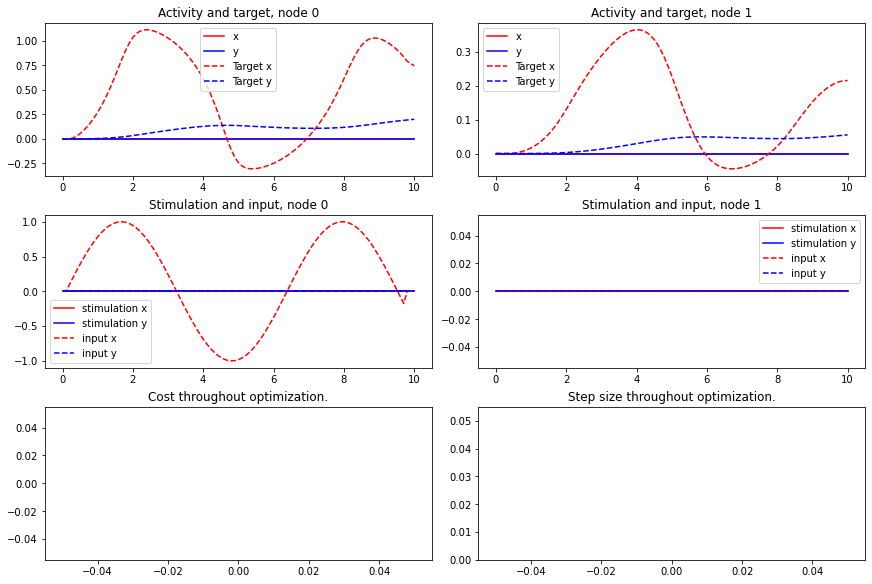

In [6]:
cmat = np.array( [[0., 1.], [0.5, 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

fhn = FHNModel(Cmat=cmat, Dmat=dmat)
fhn.params.coupling = "additive" # use additive coupling

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (fhn.params.N, len(fhn.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in y-channel in node 0

if control_mat[0,0] == 0. and control_mat[1,0] == 0:
    # if x is input channel, high connection strength can lead to numerical issues
    fhn.params.K_gl = 5. # increase for stronger connectivity, WARNING: too high value will cause numerical problems

fhn.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = np.sin(np.arange(0,duration-0.3, dt)) # other functions or random values can be used as well
fhn.params["xs_init"] = np.vstack( [x_init, x_init] )
fhn.params["ys_init"] = np.vstack( [y_init, y_init] )



# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

fhn.params["x_ext"] = input_nw[:,0,:]
fhn.params["y_ext"] = input_nw[:,1,:]

fhn.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
fhn.params["x_ext"] = zero_input_nw[:,0,:]
fhn.params["y_ext"] = zero_input_nw[:,0,:]
fhn.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)

plot_oc_network(fhn.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 1: 1.6849098053371576
Cost in iteration 2: 1.18029016784313
Cost in iteration 10: 0.11142857936425493
Cost in iteration 50: 0.001616869988977084
Cost in iteration 100: 0.0004110712294866493
Cost in iteration 200: 0.00011867489953064958
Cost in iteration 300: 4.639261934255246e-05
Cost in iteration 400: 2.128735808835483e-05
Cost in iteration 500: 1.1036664629510374e-05


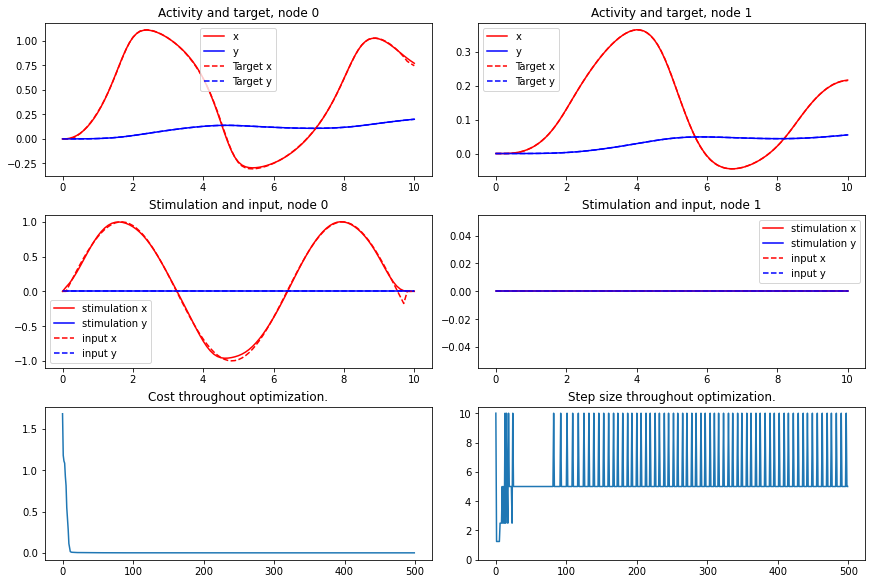

In [7]:
prec_mat = np.zeros( (fhn.params.N, len(fhn.output_vars)) )
prec_mat[1,0] = 1. # only measure in y-channel in node 1

fhn.params["x_ext"] = zero_input_nw[:,0,:]
fhn.params["y_ext"] = zero_input_nw[:,0,:]
fhn_controlled = oc_fhn.OcFhn(fhn, target, w_p=1, w_2=0, print_array=[1,2,10,50,100,200,300,400,500], control_matrix=control_mat, precision_matrix=prec_mat)

fhn_controlled.optimize(500)

state = fhn_controlled.get_xs()
control = fhn_controlled.control

plot_oc_network(fhn.params.N, duration, dt, state, target, control, input_nw, fhn_controlled.cost_history, fhn_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 1: 1.0953661598084045e-05
Cost in iteration 2: 1.087825204254886e-05
Cost in iteration 10: 1.036206184723746e-05
Cost in iteration 50: 8.224560285336917e-06
Cost in iteration 100: 6.279369320742075e-06


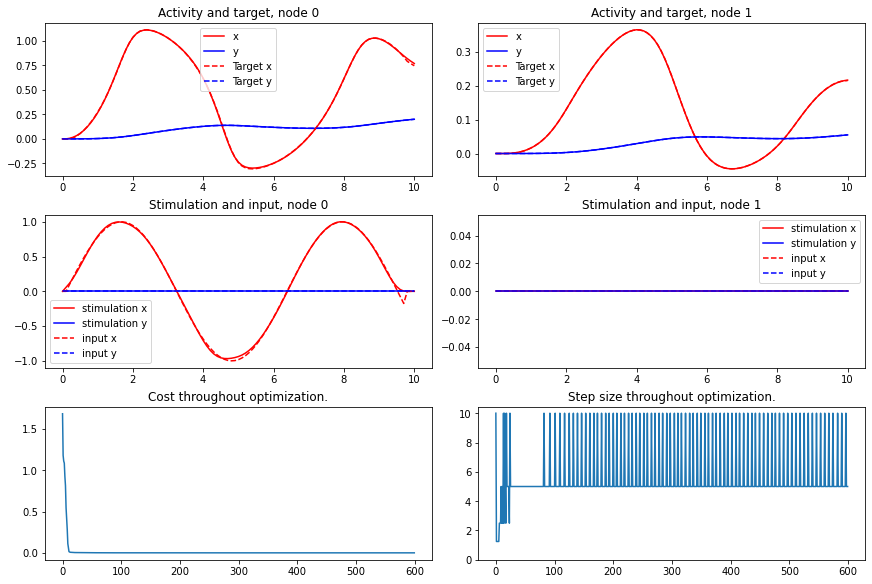

In [8]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
fhn_controlled.optimize(100)
state = fhn_controlled.get_xs()
control = fhn_controlled.control
plot_oc_network(fhn.params.N, duration, dt, state, target, control, input_nw, fhn_controlled.cost_history, fhn_controlled.step_sizes_history)